### PCA-HOG-SVM

##### Import relevant libraries

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import skimage.feature
import numpy as np


##### Load data

In [ ]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels=load_data()


##### Data pre-processing - HOG, PCA
Data normalization is applied to ensure all features are in similar scale. This ensures
stability and accelerates convergence in the CNN while preventing it from getting
trapped in the local optimum.

In [ ]:


def extract_HOG_features(data):
    hog_features = []

    # Use tqdm to create a progress bar
    for i in tqdm(range(len(data)), desc="Extracting HOG features", unit="image"):
        image = data[i, :, :, :]
        feature, _ = skimage.feature.hog(image, pixels_per_cell=[2, 2], cells_per_block=[3, 3], visualize=True, channel_axis=-1)
        hog_features.append(feature)

    return np.array(hog_features)

def pre_process(train_images, train_labels, test_images, test_labels, pca_components=None):
    # Extract HOG features
    train_images = extract_HOG_features(train_images)
    test_images = extract_HOG_features(test_images)

    # Standardize the data
    scaler = StandardScaler()
    train_images = scaler.fit_transform(train_images)
    test_images = scaler.transform(test_images)

    # Apply PCA with the specified target variance
    pca = PCA(n_components=0.95, svd_solver='full')
    train_images = pca.fit_transform(train_images)
    test_images = pca.transform(test_images)


    return train_images, train_labels, test_images, test_labels

x_train_samples = 50000
x_test_samples = 1000
train_images, train_labels, test_images, test_labels = pre_process(train_images[0:x_train_samples], train_labels[0:x_train_samples], test_images[0:x_test_samples], test_labels[0:x_test_samples])


Extracting HOG features: 100%|██████████| 1000/1000 [00:30<00:00, 33.08image/s]


##### Define model

In [ ]:
def modl():
    # Create an SVM classifier
    param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf']}
    # grid_search = GridSearchCV(SVC(), param_grid,verbose=1, cv=5,n_jobs=-1)
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale',verbose=True)
    return svm_classifier
model = modl()


##### Train

In [ ]:
start_time = time.time()
history = model.fit(train_images, train_labels.ravel())
training_time = time.time() - start_time

[LibSVM]

##### Predict test data

In [ ]:
start_time = time.time()
y_predicted = model.predict(test_images)
inference_time = time.time() - start_time

##### Compute metrics

Accuracy: 24.50%
Precision: 26.54%
Recall (Sensitivity): 24.98%
F1 Score: 24.05%
Training Time: 35.08 seconds
Inference Time: 9.1120 seconds


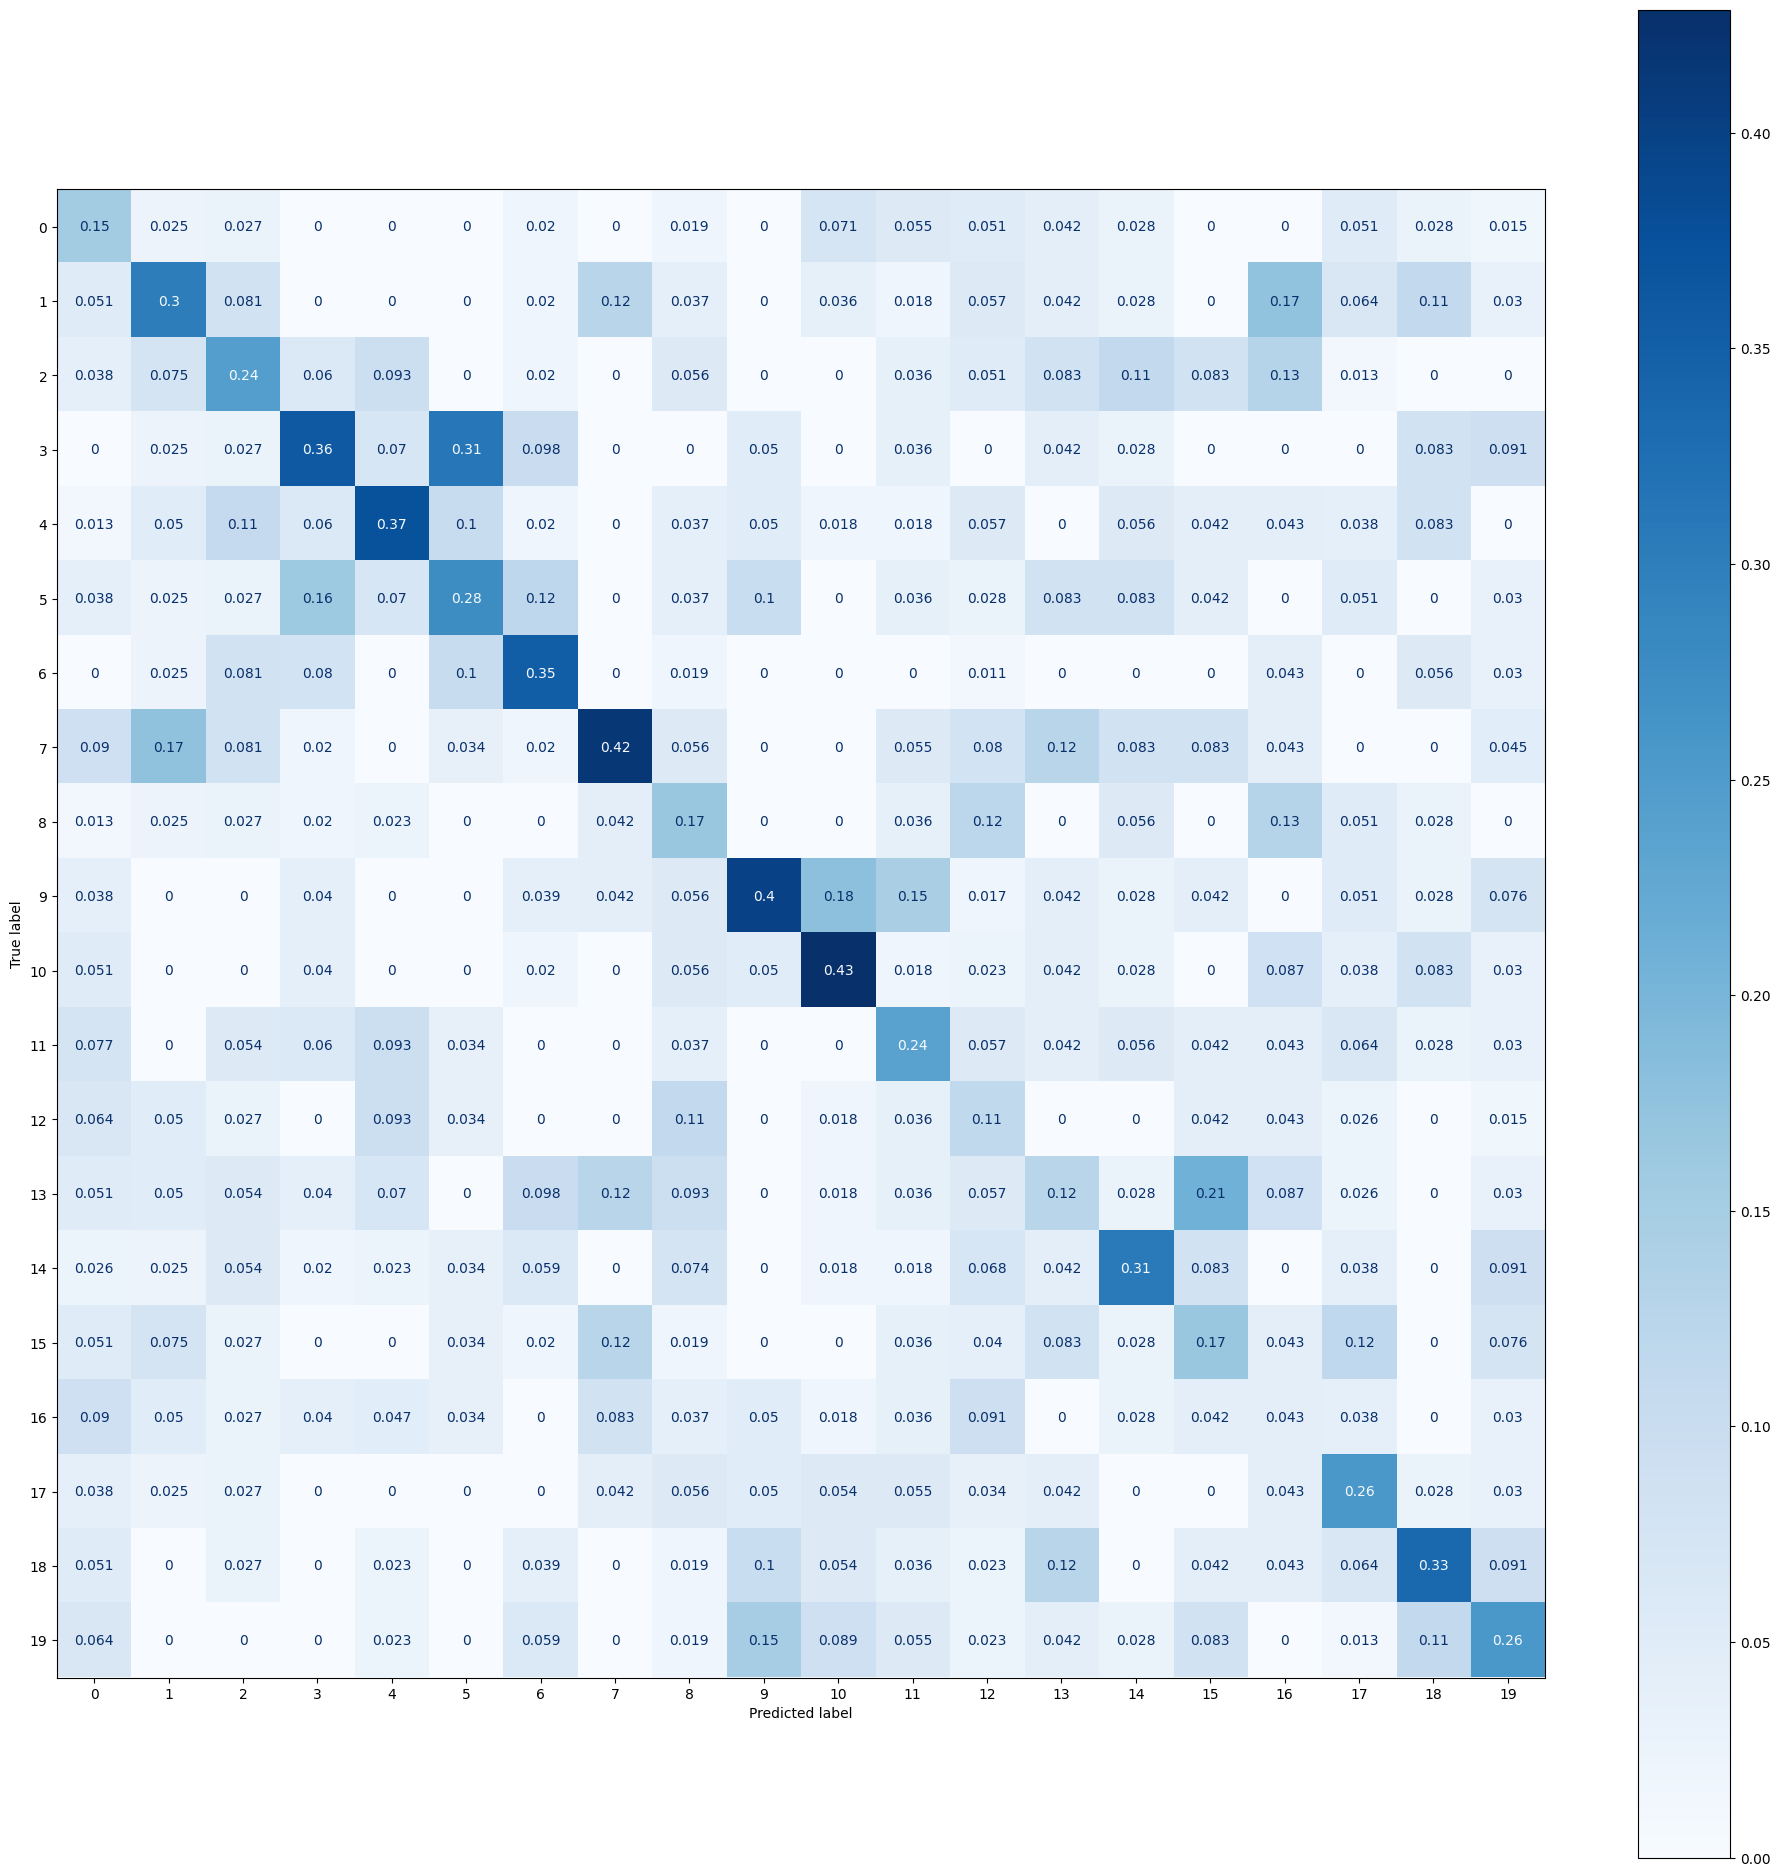

In [ ]:
def print_conf_matrix(y1,y2):
    cm = confusion_matrix(y1, y2 , normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(24,24))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def print_metrics(y1,y2):
    # Accuracy
    accuracy = accuracy_score(y1, y2)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Precision
    precision = precision_score(y1, y2, average='macro', zero_division=1)
    print(f'Precision: {precision * 100:.2f}%')

    # Recall (Sensitivity)
    recall = recall_score(y1, y2, average='macro')
    print(f'Recall (Sensitivity): {recall * 100:.2f}%')

    # F1 Score
    f1 = f1_score(y1, y2, average='macro')
    print(f'F1 Score: {f1 * 100:.2f}%')


def print_time(t1,t2):
   # Training Time
    print(f'Training Time: {t1:.2f} seconds')

    # Inference Time
    print(f'Inference Time: {t2:.4f} seconds')

print_metrics(test_labels,y_predicted)
print_time(training_time,inference_time)
print_conf_matrix(test_labels,y_predicted)